lambdaq: [[ 9.43356595  0.28311997  5.9801059  18.48414398]]
run FFVBnat time:  0:01:02.144086
alpha_nat:  5.980105903500612
beta_nat:  18.484143982656956
mu_nat:  9.43356595426578
sigma2_nat:  0.2831199724242583
iter:  602
lambdaq: [[ 9.43356595  0.28311997  5.9801059  18.48414398]]
Iterations:  602
Evidence Lower Bound:  [-35.79135953 -33.85996959 -32.2900051  -32.30172634 -31.51706248
 -30.70719121 -30.70900995 -31.08149086 -31.10537854 -31.46293515
 -31.11083762 -31.30478232 -31.16265155 -30.9719814  -30.78365072
 -31.18333583 -30.88754211 -30.98427745 -31.05672241 -30.64841082
 -30.57649953 -30.8790479  -30.52453997 -30.35801493 -30.26327473
 -30.14404854 -30.33113565 -30.05069131 -30.02959707]


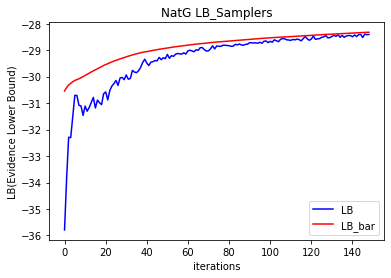

In [233]:
#Algorithm5 FFVB-Natural Gradient, CODE Reference from VBayesLab
import numpy as np
import scipy.stats as stats
from scipy.special import psi
from scipy import special
from scipy.special import gamma
from numpy.linalg import inv
import math
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
start=datetime.now()
y = [11, 12, 8, 10, 9, 8, 9, 10, 13, 7] # data
n = len(y)
#===========================
d = 4
S = 500  #number of Monte Carlo samples
momentum_weight = 0.9
eps0 = 0.01
max_iter = 2000
patience_max = 10
tau_threshold = max_iter/2
t_w = 50

#hyperparameter
alpha_hp = 1
beta_hp = 1
mu_hp = 0
sigma2_hp = 10

lambdaq = np.array([np.mean(y),.5,1,1]).reshape(1,4)# initial lambdaq
lambda_best = lambdaq


#function h_lambda_fun
def h_lambda_fun(y,mu,sigma2,alpha_hp,beta_hp,mu_hp,sigma2_hp,mu_mu,sigma2_mu,alpha_sigma2,beta_sigma2):
    log_p_mu = -1/2*np.log(2*np.pi)-1/2*np.log(sigma2_hp)-(mu-mu_hp)**2/2/sigma2_hp
    log_p_sigma2 = alpha_hp*np.log(beta_hp)-np.log(math.gamma(alpha_hp))-(alpha_hp+1)*np.log(sigma2)-beta_hp/sigma2
    log_q_mu = -1/2*np.log(2*np.pi)-1/2*np.log(sigma2_mu)-(mu-mu_mu)**2/2/sigma2_mu
    log_q_sigma2 = alpha_sigma2*np.log(beta_sigma2)-np.log(math.gamma(alpha_sigma2))-(alpha_sigma2+1)*np.log(sigma2)-beta_sigma2/sigma2;
    llh = -n/2*np.log(2*np.pi)-n/2*np.log(sigma2)-1/2/sigma2*sum((y-mu)**2)
    return log_p_mu+log_p_sigma2+llh-log_q_mu-log_q_sigma2

mu_mu = lambdaq[0,0]
sigma2_mu = lambdaq[0,1]
alpha_sigma2 = lambdaq[0,2]
beta_sigma2 = lambdaq[0,3]
h_lambda = np.zeros((S,1))#  function h_lambda
grad_log_q_lambda = np.zeros((S,d))
grad_log_q_times_h = np.zeros((S,d))
for s in range(S):
    mu = np.random.normal(mu_mu,math.sqrt(sigma2_mu),1)
    sigma2 = 1./np.random.gamma(alpha_sigma2,1/beta_sigma2,1)

    grad_log_q_lambda[s,:]=np.array([(mu-mu_mu)/sigma2_mu,
                                     -1/2/sigma2_mu+(mu-mu_mu)**2/2/sigma2_mu**2,
                                     np.log(beta_sigma2)-psi(alpha_sigma2)-np.log(sigma2),
                                     alpha_sigma2/beta_sigma2-1/sigma2]).reshape(1,4)
    h_lambda[s] = h_lambda_fun(y,mu,sigma2,alpha_hp,beta_hp,mu_hp,sigma2_hp,mu_mu,sigma2_mu,alpha_sigma2,beta_sigma2)    
    grad_log_q_times_h[s,:] = grad_log_q_lambda[s,:]*h_lambda[s]

cv = np.zeros((1,d))# control variate
for i in range(d):
    aa = np.cov(grad_log_q_times_h[:,i],grad_log_q_lambda[:,i])
    cv[0,i] = aa[0,1]/aa[1,1]
#print("CV-control variate: " ,cv)
grad_LB1= np.mean(grad_log_q_times_h[:,0])
grad_LB2= np.mean(grad_log_q_times_h[:,1])
grad_LB3= np.mean(grad_log_q_times_h[:,2])
grad_LB4= np.mean(grad_log_q_times_h[:,3])
grad_LB_nat =np.array([grad_LB1,grad_LB2,grad_LB3,grad_LB4]).reshape(1,4)
grad_LB_bar = grad_LB_nat

iter_ = 1
stop = False
#LB_50 = np.array([-1e3 for i in range(2000)])
LB = np.array([-1e3 for i in range(2000)])
#LB_200 = np.array([-1e3 for i in range(2000)])
#LB_300b = np.array([-1e3 for i in range(2000)])
#LB_500b = np.array([-1e3 for i in range(2000)])
#LB_1000 = np.array([-1e3 for i in range(2000)])
LB_bar = np.array([-1e3 for i in range(2000)])
patience = 0  

while not stop:
    mu_mu = lambdaq[0,0]
    sigma2_mu = lambdaq[0,1]
    alpha_sigma2 = lambdaq[0,2]
    beta_sigma2 = lambdaq[0,3]
    h_lambda = np.zeros((S,1))# function h_lambda
    grad_log_q_lambda = np.zeros((S,d))
    grad_log_q_times_h = np.zeros((S,d))
    grad_log_q_times_h_cv = np.zeros((S,d))
    for s in range(S):
        mu = np.random.normal(mu_mu,math.sqrt(sigma2_mu),1)
        sigma2 = 1./np.random.gamma(alpha_sigma2,1/beta_sigma2,1)

        grad_log_q_lambda[s,:]=np.array([(mu-mu_mu)/sigma2_mu,
                                     -1/2/sigma2_mu+(mu-mu_mu)**2/2/sigma2_mu**2,
                                     np.log(beta_sigma2)-psi(alpha_sigma2)-np.log(sigma2),
                                     alpha_sigma2/beta_sigma2-1/sigma2]).reshape(1,4)
        h_lambda[s] = h_lambda_fun(y,mu,sigma2,alpha_hp,beta_hp,mu_hp,sigma2_hp,mu_mu,sigma2_mu,alpha_sigma2,beta_sigma2)    
        grad_log_q_times_h[s,:] = grad_log_q_lambda[s,:]*h_lambda[s]
        grad_log_q_times_h_cv[s,:] = grad_log_q_lambda[s,:]*(h_lambda[s]-cv)
    
    cv = np.zeros((1,d))# control variate
    for i in range(d):
        aa = np.cov(grad_log_q_times_h[:,i],grad_log_q_lambda[:,i])
        cv[0,i] = aa[0,1]/aa[1,1]
    
    grad_LB1= np.mean(grad_log_q_times_h_cv[:,0])
    grad_LB2= np.mean(grad_log_q_times_h_cv[:,1])
    grad_LB3= np.mean(grad_log_q_times_h_cv[:,2])
    grad_LB4= np.mean(grad_log_q_times_h_cv[:,3])
    grad_LB =np.array([grad_LB1,grad_LB2,grad_LB3,grad_LB4]).reshape(1,4)

    #case 'ADAM'
    #g_adaptive = grad_LB
    #v_adaptive = g_adaptive**2
    #g_bar_adaptive = beta1_adap_weight*g_bar_adaptive+(1-beta1_adap_weight)*g_adaptive
    #v_bar_adaptive = beta2_adap_weight*v_bar_adaptive+(1-beta2_adap_weight)*v_adaptive
    #case ADADELTA
    #delta2_bar_previous = delta2_bar
    #g2_bar = w_adadelta*g2_bar+(1-w_adadelta)*grad_LB**2
    #rho = np.sqrt(delta2_bar_previous+eps_adadelta)/np.sqrt(g2_bar+eps_adadelta)
    #delta_lambda = rho*grad_LB
    #delta2_bar = w_adadelta*delta2_bar+(1-w_adadelta)*delta_lambda**2
    I_igam = np.array([special.polygamma(1,alpha_sigma2),-1/beta_sigma2,-1/beta_sigma2,alpha_sigma2/beta_sigma2**2]).reshape(2,2) #inverse Fisher matrix
    a = LA.inv(I_igam)@grad_LB[0,2:4].reshape(2,1)
    grad_LB_nat = np.array([sigma2_mu*grad_LB[0,0],2*sigma2_mu**2*grad_LB[0,1],a[0,0],a[1,0]])
    grad_LB_bar = momentum_weight*grad_LB_bar+(1-momentum_weight)*grad_LB_nat
    #lambdaq = lambdaq+delta_lambda
    if iter_>=tau_threshold:
        stepsize = eps0*tau_threshold/iter_
    else:
        stepsize = eps0
    #lambdaq = lambdaq+delta_lambda
    #lambdaq = lambdaq+stepsize*g_bar_adaptive/np.sqrt(v_bar_adaptive)
    lambdaq = lambdaq+stepsize*grad_LB_bar
    #LB_50[iter_] = np.mean(h_lambda)
    #LB_100b[iter_] = np.mean(h_lambda)
    #LB_200[iter_] = np.mean(h_lambda)
    #LB_300b[iter_] = np.mean(h_lambda)
    LB[iter_] = np.mean(h_lambda)
    #LB_1000[iter_] = np.mean(h_lambda)

    if iter_>=t_w:
        LB_bar[iter_-t_w+1] = np.mean(LB[iter_-t_w+1:iter_])

    if iter_>t_w:
        if LB_bar[iter_-t_w+1]>=max(LB_bar):
            lambda_best = lambdaq
            patience = 0
        else:
            patience = patience+1

    if patience>patience_max or iter_>max_iter:
        stop = True
    iter_ = iter_+1

lambdaq = lambda_best
mu_mu = lambdaq[0,0]
sigma2_mu = lambdaq[0,1]
alpha_sigma2 = lambdaq[0,2]
beta_sigma2 = lambdaq[0,3]  
print("lambdaq:",lambdaq)
print("run FFVBnat time: ", datetime.now()-start)
print("=======================================")
print("alpha_nat: ", alpha_sigma2)
print("beta_nat: ", beta_sigma2)
print("mu_nat: ", mu_mu)
print("sigma2_nat: ", sigma2_mu)
print("iter: ", iter_)
print("lambdaq:",lambdaq)
print("Iterations: ",iter_)
print("Evidence Lower Bound: ",LB[1:30])
plt.plot(LB[1:150], color="b",label="LB")
plt.plot(LB_bar[1:150], color="r",label="LB_bar")
plt.title("NatG LB_Samplers") 
plt.xlabel("iterations"); plt.ylabel('LB(Evidence Lower Bound)')
plt.legend()
plt.show()

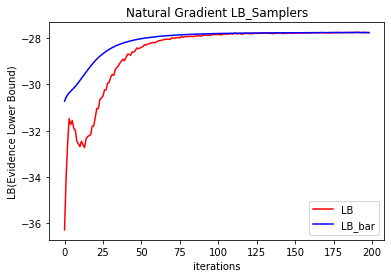

In [228]:
plt.plot(LB[1:200], color="r",label="LB")
plt.plot(LB_bar[1:200], color="b",label="LB_bar")
plt.title("Natural Gradient LB_Samplers") 
plt.xlabel("iterations"); plt.ylabel('LB(Evidence Lower Bound)')
plt.legend()
plt.show()

In [ ]:
#NG sampling 3000, esp0 = 0.001
#lambdaq: [[ 9.49294567  0.30461358  4.41260443 13.29857541]]
#run FFVBnat time:  0:08:15.629735
#=======================================
#alpha_nat:  4.412604434112599
#beta_nat:  13.298575411308658
#mu_nat:  9.492945665812618
#sigma2_nat:  0.3046135831909158
#iter:  1196

In [ ]:
#NG sampling 2000, esp0 = 0.001
#lambdaq: [[ 9.52512944  0.31529138  3.67946128 10.77615865]]
#run FFVBnat time:  0:04:27.038425
#=======================================
#alpha_nat:  3.679461278215872
#beta_nat:  10.77615864795799
#mu_nat:  9.525129435111127
#sigma2_nat:  0.3152913834741553
#iter:  798

In [ ]:
#NG sampling 1000, esp0 = 0.001
#lambdaq: [[ 9.51888113  0.30683486  3.87644085 11.43757299]]
#run FFVBnat time:  0:02:08.865098
#=======================================
#alpha_nat:  3.8764408548155767
#beta_nat:  11.437572992526896
#mu_nat:  9.518881129264583
#sigma2_nat:  0.3068348551680677
#iter:  891

In [ ]:
#NG sampling 500, esp0 = 0.001
#lambdaq: [[9.56883944 0.321906   3.25208494 9.18726472]]
#run FFVBnat time:  0:00:45.292862
#=======================================
#alpha_nat:  3.252084943806573
#beta_nat:  9.187264718168347
#mu_nat:  9.568839440539657
#sigma2_nat:  0.3219059957853218
#iter:  626

In [55]:
#sampling 10, esp0 = 0.01
#lambdaq: [[ 9.36413154  0.44288114  5.06840529 17.66013751]]
#run FFVBnat time:  0:00:00.431635
#=======================================
#alpha_nat:  5.0684052949059994
#beta_nat:  17.660137514066523
#mu_nat:  9.364131543199278
#sigma2_nat:  0.44288114276175666
#iter:  210

array([-1000.        ,   -37.27953086,   -32.73703311, ...,
       -1000.        , -1000.        , -1000.        ])

In [ ]:
#sampling 1000, esp0 = 0.01
#lambdaq: [[ 9.42858808  0.26136033  5.96905362 18.3411461 ]]
#run FFVBnat time:  0:01:18.236803
#=======================================
#alpha_nat:  5.969053623797469
#beta_nat:  18.341146099752482
#mu_nat:  9.428588082066174
#sigma2_nat:  0.2613603337630963
#iter:  505


In [18]:
#sampling 500, esp0 = 0.01
#lambdaq: [[ 9.43991136  0.28516665  5.95366736 18.403984  ]]
#run FFVBnat time:  0:00:30.389793
#=======================================
#alpha_nat:  5.953667363765442
#beta_nat:  18.403983997856095
#mu_nat:  9.439911355576221
#sigma2_nat:  0.2851666501923449
#iter:  479


In [123]:
#sampling 500, esp0 = 0.001
#lambdaq: [[ 9.54098979  0.33331066  3.47502429 10.13399733]]
#run FFVBnat time:  0:00:48.019080
#=======================================
#alpha_nat:  3.4750242851907895
#beta_nat:  10.133997334577035
#mu_nat:  9.540989788494942
#sigma2_nat:  0.33331065590914644
#iter:  712
lb500b = LB_500b
lb500b

array([-1000.        ,   -37.25283804,   -36.92182268, ...,
       -1000.        , -1000.        , -1000.        ])

In [104]:
#sampling 100, esp0 = 0.01
#lambdaq: [[ 9.40701509  0.28719055  5.09367525 16.22714029]]
#run FFVBnat time:  0:00:02.573620
#=======================================
#alpha_nat:  5.093675245826108
#beta_nat:  16.22714029052886
#mu_nat:  9.407015089943283
#sigma2_nat:  0.28719055405778016
#iter:  192
lb100 = LB_100
lb100

array([-1000.        ,   -35.62931116,   -32.40333455, ...,
       -1000.        , -1000.        , -1000.        ])

In [120]:
#sampling 100, esp0 = 0.001
#lambdaq: [[9.61695006 0.32883744 2.70940713 7.24802441]]
#run FFVBnat time:  0:00:06.617748
#=======================================
#alpha_nat:  2.7094071341700863
#beta_nat:  7.248024410836557
#mu_nat:  9.616950059560306
#sigma2_nat:  0.3288374359687007
#iter:  452
lb100b = LB_100b
lb100b

array([-1000.        ,   -39.14833518,   -35.08797333, ...,
       -1000.        , -1000.        , -1000.        ])

In [ ]:
#sampling 100 eps0=0.01
#lambdaq: [[ 9.33455426  0.34656759  5.41690808 18.11601165]]
#run FFVBnat time:  0:00:02.990544
#=======================================
#alpha_nat:  5.41690807729866
#beta_nat:  18.116011650280402
#mu_nat:  9.334554264088016
#sigma2_nat:  0.34656758890494704
#iter:  244

In [ ]:
#sampling 300 eps0=0.01
#lambdaq: [[ 9.44316545  0.31185275  5.68554066 18.08733107]]
#run FFVBnat time:  0:00:10.497827
#=======================================
#alpha_nat:  5.685540663041745
#beta_nat:  18.087331071493413
#mu_nat:  9.443165453604864
#sigma2_nat:  0.3118527511880198
#iter:  293

In [ ]:
#sampling 50 eps0=0.01
#lambdaq: [[ 9.35737723  0.36742544  5.61292487 18.98395522]]
#run FFVBnat time:  0:00:01.770868
#=======================================
#alpha_nat:  5.612924866842906
#beta_nat:  18.98395522036445
#mu_nat:  9.357377229244493
#sigma2_nat:  0.36742544197227933
#iter:  245

In [ ]:
#sampling 200 eps0=0.01
#lambdaq: [[ 9.43796602  0.31455281  5.62627618 17.86243117]]
#run FFVBnat time:  0:00:07.116904
#=======================================
#alpha_nat:  5.6262761753212205
#beta_nat:  17.862431168242406
#mu_nat:  9.43796602453129
#sigma2_nat:  0.3145528069226347
#iter:  266

In [114]:
#sampling 300 eps0=0.001
#lambdaq: [[9.54428951 0.3491096  2.87496172 8.22312668]]
#run FFVBnat time:  0:00:19.469405
#=======================================
#alpha_nat:  2.8749617158970353
#beta_nat:  8.223126677483037
#mu_nat:  9.544289512047893
#sigma2_nat:  0.3491095953022435
#iter:  515
lb300b = LB_300b
lb300b

array([-1000.        ,   -36.08188257,   -35.63374729, ...,
       -1000.        , -1000.        , -1000.        ])

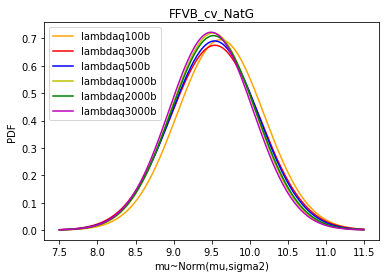

In [217]:
lambdaq100b =[9.61695006, 0.32883744, 2.70940713, 7.24802441]
lambdaq300b =[9.54428951, 0.3491096, 2.87496172, 8.22312668]
lambdaq500b =[9.54098979, 0.33331066, 3.47502429, 10.13399733]
lambdaq1000b =[ 9.51888113, 0.30683486, 3.87644085, 11.43757299]
lambdaq2000b =[ 9.52512944, 0.31529138, 3.67946128, 10.77615865]
lambdaq3000b =[ 9.49294567, 0.30461358, 4.41260443, 13.29857541]
x = np.linspace(7.5, 11.5, 200)
plt.plot(x, stats.norm.pdf(x, lambdaq100b[0], np.sqrt(lambdaq100b[1])),"orange",label="lambdaq100b")
plt.plot(x, stats.norm.pdf(x, lambdaq300b[0], np.sqrt(lambdaq300b[1])),"r",label="lambdaq300b")
plt.plot(x, stats.norm.pdf(x, lambdaq500b[0], np.sqrt(lambdaq500b[1])),"b",label="lambdaq500b")
plt.plot(x, stats.norm.pdf(x, lambdaq1000b[0], np.sqrt(lambdaq1000b[1])),"y",label="lambdaq1000b")
plt.plot(x, stats.norm.pdf(x, lambdaq2000b[0], np.sqrt(lambdaq2000b[1])),"g",label="lambdaq2000b")
plt.plot(x, stats.norm.pdf(x, lambdaq3000b[0], np.sqrt(lambdaq3000b[1])),"m",label="lambdaq3000b")
plt.title('FFVB_cv_NatG') 
plt.xlabel('mu~Norm(mu,sigma2)')
plt.ylabel('PDF')
plt.legend()
plt.show()

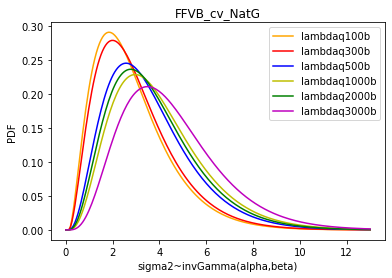

In [218]:
x = np.linspace (0, 13, 200) 
plt.plot(x, stats.gamma.pdf(x, a=lambdaq100b[2], loc=1/lambdaq100b[3]),"orange",label="lambdaq100b")
plt.plot(x, stats.gamma.pdf(x, a=lambdaq300b[2], loc=1/lambdaq300b[3]),"r",label="lambdaq300b")
plt.plot(x, stats.gamma.pdf(x, a=lambdaq500b[2], loc=1/lambdaq500b[3]),"b",label="lambdaq500b")
plt.plot(x, stats.gamma.pdf(x, a=lambdaq1000b[2], loc=1/lambdaq1000b[3]),"y",label="lambdaq1000b")
plt.plot(x, stats.gamma.pdf(x, a=lambdaq2000b[2], loc=1/lambdaq2000b[3]),"g",label="lambdaq2000b")
plt.plot(x, stats.gamma.pdf(x, a=lambdaq3000b[2], loc=1/lambdaq3000b[3]),"m",label="lambdaq3000b")
plt.title('FFVB_cv_NatG') 
plt.xlabel('sigma2~invGamma(alpha,beta)')
plt.ylabel('PDF')
plt.legend()
plt.show()

In [85]:
lb50 = LB_50
lb50

array([-1000.        ,   -37.92925814,   -34.67390144, ...,
       -1000.        , -1000.        , -1000.        ])

In [58]:
lb200 =LB_200
lb200

array([-1000.        ,   -39.35325051,   -33.95001261, ...,
       -1000.        , -1000.        , -1000.        ])

In [60]:
lb300 = LB_300
lb300

array([-1000.        ,   -36.61104292,   -33.33910556, ...,
       -1000.        , -1000.        , -1000.        ])

In [62]:
lb500 = LB_500
lb500

array([-1000.        ,   -37.06019257,   -33.45131967, ...,
       -1000.        , -1000.        , -1000.        ])

In [64]:
lb1000 = LB_1000
lb1000

array([-1000.        ,   -36.40995494,   -34.89907041, ...,
       -1000.        , -1000.        , -1000.        ])

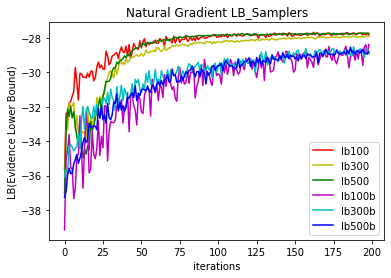

In [202]:
#plt.plot(lb50[1:200], color="orange",label="lb50")
plt.plot(lb100[1:200], color="r",label="lb100")
#plt.plot(lb200[1:200], color="b",label="lb200")
plt.plot(lb300[1:200], color="y",label="lb300")
plt.plot(lb500[1:200], color="g",label="lb500")
#plt.plot(lb1000[1:200], color="m",label="lb1000")
plt.plot(lb100b[1:200], color="m",label="lb100b")
plt.plot(lb300b[1:200], color="c",label="lb300b")
plt.plot(lb500b[1:200], color="b",label="lb500b")
plt.title("Natural Gradient LB_Samplers") 
plt.xlabel("iterations"); plt.ylabel('LB(Evidence Lower Bound)')
plt.legend()
plt.show()

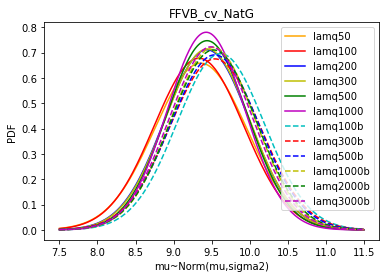

In [227]:
lambdaq50 = [ 9.35737723, 0.36742544, 5.61292487, 18.98395522]
lambdaq100 =[ 9.33455426, 0.34656759, 5.41690808, 18.11601165]
lambdaq200 =[ 9.43796602, 0.31455281, 5.62627618, 17.86243117]
lambdaq300 =[ 9.44316545, 0.31185275, 5.68554066, 18.08733107]
lambdaq500 =[ 9.43991136, 0.28516665, 5.95366736, 18.403984  ]
lambdaq1000 =[ 9.42858808, 0.26136033, 5.96905362, 18.3411461 ]
x = np.linspace(7.5, 11.5, 200)
plt.plot(x, stats.norm.pdf(x, lambdaq50[0], np.sqrt(lambdaq50[1])),"orange",label="lamq50")
plt.plot(x, stats.norm.pdf(x, lambdaq100[0], np.sqrt(lambdaq100[1])),"r",label="lamq100")
plt.plot(x, stats.norm.pdf(x, lambdaq200[0], np.sqrt(lambdaq200[1])),"b",label="lamq200")
plt.plot(x, stats.norm.pdf(x, lambdaq300[0], np.sqrt(lambdaq300[1])),"y",label="lamq300")
plt.plot(x, stats.norm.pdf(x, lambdaq500[0], np.sqrt(lambdaq500[1])),"g",label="lamq500")
plt.plot(x, stats.norm.pdf(x, lambdaq1000[0], np.sqrt(lambdaq1000[1])),"m",label="lamq1000")
plt.plot(x, stats.norm.pdf(x, lambdaq100b[0], np.sqrt(lambdaq100b[1])),"c--",label="lamq100b")
plt.plot(x, stats.norm.pdf(x, lambdaq300b[0], np.sqrt(lambdaq300b[1])),"r--",label="lamq300b")
plt.plot(x, stats.norm.pdf(x, lambdaq500b[0], np.sqrt(lambdaq500b[1])),"b--",label="lamq500b")
plt.plot(x, stats.norm.pdf(x, lambdaq1000b[0], np.sqrt(lambdaq1000b[1])),"y--",label="lamq1000b")
plt.plot(x, stats.norm.pdf(x, lambdaq2000b[0], np.sqrt(lambdaq2000b[1])),"g--",label="lamq2000b")
plt.plot(x, stats.norm.pdf(x, lambdaq3000b[0], np.sqrt(lambdaq3000b[1])),"m--",label="lamq3000b")
plt.title('FFVB_cv_NatG') 
plt.xlabel('mu~Norm(mu,sigma2)')
plt.ylabel('PDF')
plt.legend()
plt.show()


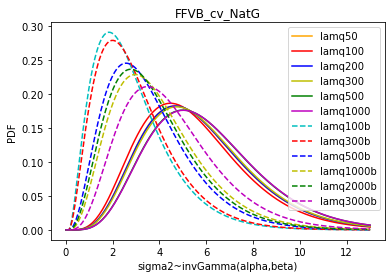

In [225]:
x = np.linspace (0, 13, 200) 
plt.plot(x, stats.gamma.pdf(x, a=lambdaq50[2], loc=1/lambdaq50[3]),"orange",label="lamq50")
plt.plot(x, stats.gamma.pdf(x, a=lambdaq100[2], loc=1/lambdaq50[3]),"r",label="lamq100")
plt.plot(x, stats.gamma.pdf(x, a=lambdaq200[2], loc=1/lambdaq50[3]),"b",label="lamq200")
plt.plot(x, stats.gamma.pdf(x, a=lambdaq300[2], loc=1/lambdaq50[3]),"y",label="lamq300")
plt.plot(x, stats.gamma.pdf(x, a=lambdaq500[2], loc=1/lambdaq50[3]),"g",label="lamq500")
plt.plot(x, stats.gamma.pdf(x, a=lambdaq1000[2], loc=1/lambdaq50[3]),"m",label="lamq1000")
plt.plot(x, stats.gamma.pdf(x, a=lambdaq100b[2], loc=1/lambdaq100b[3]),"c--",label="lamq100b")
plt.plot(x, stats.gamma.pdf(x, a=lambdaq300b[2], loc=1/lambdaq300b[3]),"r--",label="lamq300b")
plt.plot(x, stats.gamma.pdf(x, a=lambdaq500b[2], loc=1/lambdaq500b[3]),"b--",label="lamq500b")
plt.plot(x, stats.gamma.pdf(x, a=lambdaq1000b[2], loc=1/lambdaq1000b[3]),"y--",label="lamq1000b")
plt.plot(x, stats.gamma.pdf(x, a=lambdaq2000b[2], loc=1/lambdaq2000b[3]),"g--",label="lamq2000b")
plt.plot(x, stats.gamma.pdf(x, a=lambdaq3000b[2], loc=1/lambdaq3000b[3]),"m--",label="lamq3000b")
plt.title('FFVB_cv_NatG') 
plt.xlabel('sigma2~invGamma(alpha,beta)')
plt.ylabel('PDF')
plt.legend()
plt.show()

In [ ]:
#NG mu-Normal(mu,sigma2)

In [ ]:
#NG sigma2-invGamma(alpha,beta)

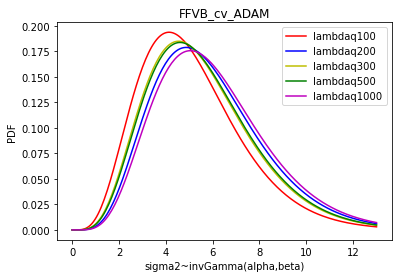

In [189]:
#ADAM
lambdaqAdamAlpha = [5.076,5.813,5.490,5.552,5.996]
lambdaqAdamBeta = [16.093,18.140,17.883,17.634,18.970]
x = np.linspace (0, 13, 200) 
plt.plot(x, stats.gamma.pdf(x, a=lambdaqAdamAlpha[0], loc=1/lambdaqAdamBeta[0]),"r",label="lambdaq100")
plt.plot(x, stats.gamma.pdf(x, a=lambdaqAdamAlpha[1], loc=1/lambdaqAdamBeta[1]),"b",label="lambdaq200")
plt.plot(x, stats.gamma.pdf(x, a=lambdaqAdamAlpha[2], loc=1/lambdaqAdamBeta[2]),"y",label="lambdaq300")
plt.plot(x, stats.gamma.pdf(x, a=lambdaqAdamAlpha[3], loc=1/lambdaqAdamBeta[3]),"g",label="lambdaq500")
plt.plot(x, stats.gamma.pdf(x, a=lambdaqAdamAlpha[4], loc=1/lambdaqAdamBeta[4]),"m",label="lambdaq1000")
plt.title('FFVB_cv_ADAM') 
plt.xlabel('sigma2~invGamma(alpha,beta)')
plt.ylabel('PDF')
plt.legend()
plt.show()

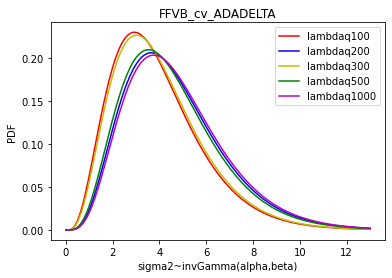

In [187]:
#ADADELTA
lambdaqAdadeltaAlpha = [3.843,4.582,3.936,4.457,4.685]
lambdaqAdadeltaBeta = [11.653,14.184,12.016,13.827,14.468]
x = np.linspace (0, 13, 200) 
plt.plot(x, stats.gamma.pdf(x, a=lambdaqAdadeltaAlpha[0], loc=1/lambdaqAdadeltaBeta[0]),"r",label="lambdaq100")
plt.plot(x, stats.gamma.pdf(x, a=lambdaqAdadeltaAlpha[1], loc=1/lambdaqAdadeltaBeta[1]),"b",label="lambdaq200")
plt.plot(x, stats.gamma.pdf(x, a=lambdaqAdadeltaAlpha[2], loc=1/lambdaqAdadeltaBeta[2]),"y",label="lambdaq300")
plt.plot(x, stats.gamma.pdf(x, a=lambdaqAdadeltaAlpha[3], loc=1/lambdaqAdadeltaBeta[3]),"g",label="lambdaq500")
plt.plot(x, stats.gamma.pdf(x, a=lambdaqAdadeltaAlpha[4], loc=1/lambdaqAdadeltaBeta[4]),"m",label="lambdaq1000")
plt.title('FFVB_cv_ADADELTA') 
plt.xlabel('sigma2~invGamma(alpha,beta)')
plt.ylabel('PDF')
plt.legend()
plt.show()

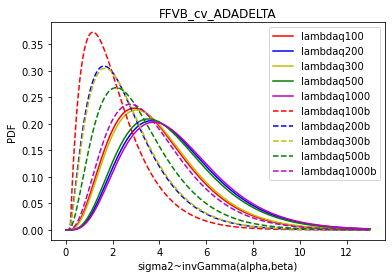

In [190]:
#ADADELTA
lambdaqAdadeltaAlphab = [1.967,2.490,2.534,3.037,3.661]
lambdaqAdadeltaBetab = [5.243,7.086,7.114,8.773,11.003]
x = np.linspace (0, 13, 200)
plt.plot(x, stats.gamma.pdf(x, a=lambdaqAdadeltaAlpha[0], loc=1/lambdaqAdadeltaBeta[0]),"r",label="lambdaq100")
plt.plot(x, stats.gamma.pdf(x, a=lambdaqAdadeltaAlpha[1], loc=1/lambdaqAdadeltaBeta[1]),"b",label="lambdaq200")
plt.plot(x, stats.gamma.pdf(x, a=lambdaqAdadeltaAlpha[2], loc=1/lambdaqAdadeltaBeta[2]),"y",label="lambdaq300")
plt.plot(x, stats.gamma.pdf(x, a=lambdaqAdadeltaAlpha[3], loc=1/lambdaqAdadeltaBeta[3]),"g",label="lambdaq500")
plt.plot(x, stats.gamma.pdf(x, a=lambdaqAdadeltaAlpha[4], loc=1/lambdaqAdadeltaBeta[4]),"m",label="lambdaq1000")
plt.plot(x, stats.gamma.pdf(x, a=lambdaqAdadeltaAlphab[0], loc=1/lambdaqAdadeltaBetab[0]),"r--",label="lambdaq100b")
plt.plot(x, stats.gamma.pdf(x, a=lambdaqAdadeltaAlphab[1], loc=1/lambdaqAdadeltaBetab[1]),"b--",label="lambdaq200b")
plt.plot(x, stats.gamma.pdf(x, a=lambdaqAdadeltaAlphab[2], loc=1/lambdaqAdadeltaBetab[2]),"y--",label="lambdaq300b")
plt.plot(x, stats.gamma.pdf(x, a=lambdaqAdadeltaAlphab[3], loc=1/lambdaqAdadeltaBetab[3]),"g--",label="lambdaq500b")
plt.plot(x, stats.gamma.pdf(x, a=lambdaqAdadeltaAlphab[4], loc=1/lambdaqAdadeltaBetab[4]),"m--",label="lambdaq1000b")
plt.title('FFVB_cv_ADADELTA') 
plt.xlabel('sigma2~invGamma(alpha,beta)')
plt.ylabel('PDF')
plt.legend()
plt.show()